In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df = pd.read_csv('final.csv')
df = df[pd.notnull(df['label'])]
print(df.head(10))
print('\n Number of words before pre-processing: ')
print(df['text'].apply(lambda x: len(x.split(' '))).sum())

                                                text  sentiment  label
0  Peaceful CAA opposers not 'traitors, anti-nati...   0.166667      1
1  Gujarat College Girls Made To Strip To Detect ...   0.000000      0
2  Mns dont have d rights to impose nrc n check a...   0.100000      1
3  Yea right. He has no business being appointed ...   0.285714      1
4  @chennai police की बरबरियत Anti-CAA protestors...  -0.187500     -1
5  #WorldAgainstCAA_NRC_NPR Raise your voice to c...  -0.155556     -1
6  The final NRC data of Assam has vanished.@Indi...   0.000000      0
7  @चेन्नई पुलिस की बरबरियत Anti-CAA protestors i...  -0.187500     -1
8  That tells either you failed to Listen to him ...  -0.100000     -1
9  Masha Allah. What's name of this baby? Look at...   0.500000      1

 Number of words before pre-processing: 
83507


# Dataset Count

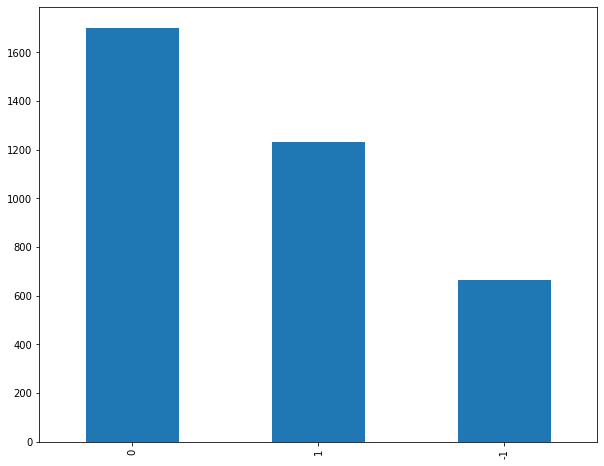

In [2]:
my_tags = ['0','1','-1']
plt.figure(figsize=(10,8))
df.label.value_counts().plot(kind='bar');

Text(0.5, 1.0, 'Data Set Count')

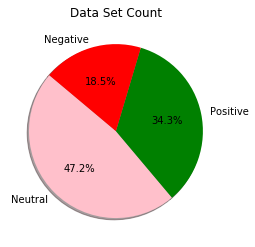

In [3]:
counts = df.label.value_counts(normalize=True) * 100
labels = 'Neutral', 'Positive','Negative'
colors = ['pink', 'green', 'Red']
#explode = (1, 1, 0, 0)  # explode 1st slice

plt.pie(counts, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Data Set Count")

# Text Preprocessing

In [4]:
import nltk
#nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
df['text'] = df['text'].apply(clean_text)
print('\n Number of words after pre-processing: ')
df['text'].apply(lambda x: len(x.split(' '))).sum()


 Number of words after pre-processing: 


56260

# Train-Test Split

In [5]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Naive Bayes Classifier

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


Accuracy 0.6759259259259259
              precision    recall  f1-score   support

           0       1.00      0.15      0.27       222
           1       0.64      0.95      0.76       513
          -1       0.75      0.60      0.67       345

    accuracy                           0.68      1080
   macro avg       0.79      0.57      0.56      1080
weighted avg       0.75      0.68      0.63      1080



Text(0.5, 1.0, 'Navie bayes counts')

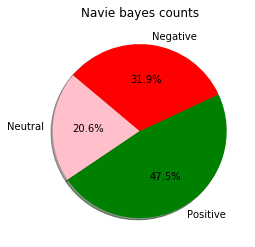

In [7]:
Navie_report=classification_report(y_test, y_pred,target_names=my_tags,output_dict=True)
Navie=pd.DataFrame(Navie_report).transpose()

#Taking only support because it has the number of predicted values
count=Navie['support'].iloc[0:3]
label= 'Neutral','Positive','Negative'
colors=['pink', 'green', 'Red']
plt.pie(count, labels=label, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Navie bayes counts")

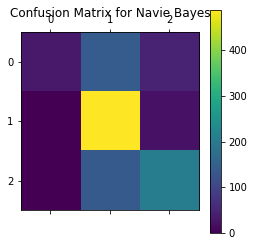

In [8]:
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.title("Confusion Matrix for Navie Bayes")
plt.colorbar()



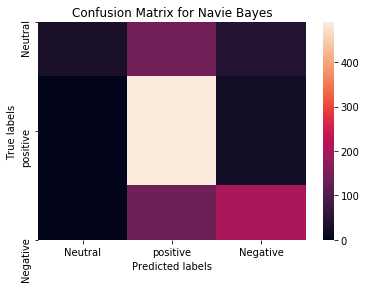

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Navie Bayes'); 
ax.xaxis.set_ticklabels(['Neutral', 'positive','Negative']); ax.yaxis.set_ticklabels(['Neutral', 'positive','Negative']);

# Linear SVM

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy 0.7333333333333333
              precision    recall  f1-score   support

           0       0.96      0.39      0.56       222
           1       0.69      0.94      0.79       513
          -1       0.78      0.65      0.71       345

    accuracy                           0.73      1080
   macro avg       0.81      0.66      0.69      1080
weighted avg       0.77      0.73      0.72      1080



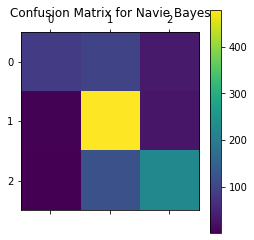

In [11]:
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.title("Confusion Matrix for Navie Bayes")
plt.colorbar()

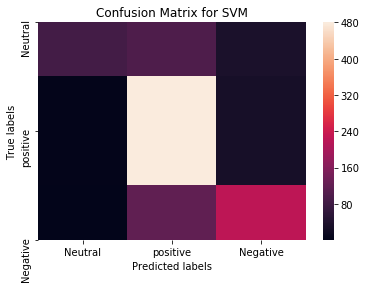

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SVM'); 
ax.xaxis.set_ticklabels(['Neutral', 'positive','Negative']); ax.yaxis.set_ticklabels(['Neutral', 'positive','Negative']);

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200,random_state=42)),
               ])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy 0.8148148148148148
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       222
           1       0.75      0.97      0.85       513
          -1       0.88      0.76      0.82       345

    accuracy                           0.81      1080
   macro avg       0.87      0.76      0.79      1080
weighted avg       0.84      0.81      0.81      1080



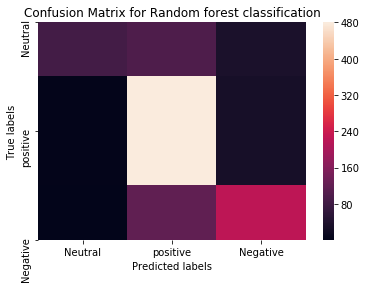

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random forest classification'); 
ax.xaxis.set_ticklabels(['Neutral', 'positive','Negative']); ax.yaxis.set_ticklabels(['Neutral', 'positive','Negative']);

# Wordcloud - 100 words

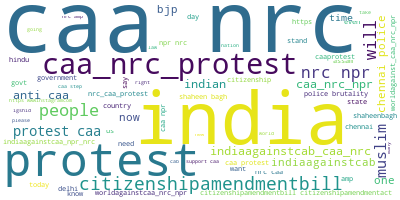

In [15]:
import pandas as pd
import re
from wordcloud import WordCloud

df = pd.read_csv('final.csv')

# Remove punctuation
df['text'] = df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the text to lowercase
df['text'] = df['text'].map(lambda x: x.lower())

# Join the different processed text together.
long_string = ','.join(list(df['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=100, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

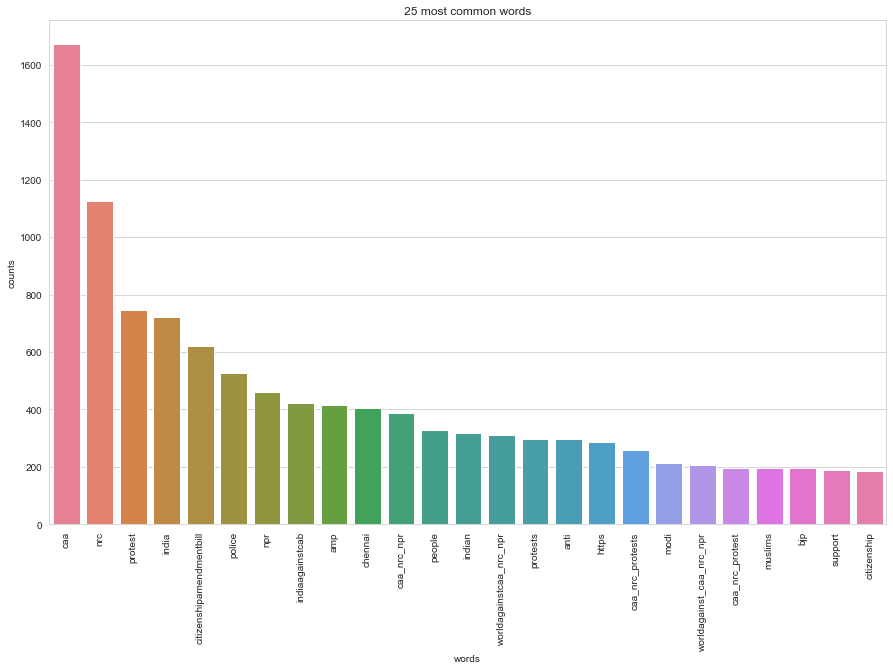

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_25_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:25]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='25 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed text
count_data = count_vectorizer.fit_transform(df['text'])
# Visualise the 25 most common words
plot_25_most_common_words(count_data, count_vectorizer)

In [17]:
!GetOldTweets3 --querysearch "nrc" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [18]:
nrc = pd.read_csv("output_got.csv")

In [19]:
!GetOldTweets3 --querysearch "caa" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [20]:
caa = pd.read_csv("output_got.csv")

In [21]:
!GetOldTweets3 --querysearch "CAA_NRC" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [22]:
caa_nrc = pd.read_csv("output_got.csv")

In [23]:
!GetOldTweets3 --querysearch "CAA_NRC_Protests" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [24]:
caa_nrc_protests = pd.read_csv("output_got.csv")

In [25]:
!GetOldTweets3 --querysearch "citizenshipamendmentbill" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [26]:
bill = pd.read_csv("output_got.csv")

In [27]:
#indiaagainstcab
!GetOldTweets3 --querysearch "indiaagainstcab" --since 2019-12-15 --until 2020-02-15 --maxtweets 600 --lang en --emoji unicode

Saved 600
Done. Output file generated "output_got.csv".


In [28]:
against=pd.read_csv("output_got.csv")

In [29]:
pList=[nrc,caa,caa_nrc,caa_nrc_protests,bill,against]
Ana_table = pd.concat(pList)
sentiment=pd.DataFrame(Ana_table['text'])
sentiment=sentiment.dropna()

In [30]:
sentiment['text'] = sentiment['text'].apply(clean_text)
print('\n Number of words after pre-processing: ')
sentiment['text'].apply(lambda x: len(x.split(' '))).sum()


 Number of words after pre-processing: 


56798

In [31]:
senti=sentiment.text
label_rf=rf.predict(senti)

In [32]:
analysing_dataframe=pd.DataFrame({'tweet':senti,'label':label_rf})

In [33]:
 analysing_dataframe.label.value_counts(normalize=True) * 100



 0    51.333333
 1    33.222222
-1    15.444444
Name: label, dtype: float64

Text(0.5, 1.0, 'Result of sentiment analaysis')

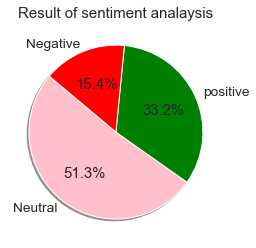

In [34]:
counts = analysing_dataframe.label.value_counts(normalize=True) * 100
labels = 'Neutral','positive','Negative'
colors = ['pink', 'green', 'Red']
explode = (1, 1, 0, 0)  # explode 1st slice

plt.pie(counts, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Result of sentiment analaysis")

In [35]:
Positive=analysing_dataframe[analysing_dataframe.label==1]
Negative=analysing_dataframe[analysing_dataframe.label==-1]

/Users/rupakulasaiabhishek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/rupakulasaiabhishek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


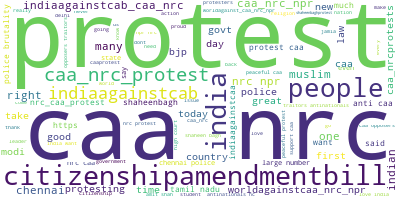

In [36]:
import re
from wordcloud import WordCloud

# Remove punctuation
Positive['tweet']= Positive['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the text to lowercase
Positive['tweet'] = Positive['tweet'].map(lambda x: x.lower())

# Join the different processed text together.
long_string = ','.join(list(Positive['tweet'].values))

wordcloud = WordCloud(background_color="white", max_words=100, contour_width=100, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

/Users/rupakulasaiabhishek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rupakulasaiabhishek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


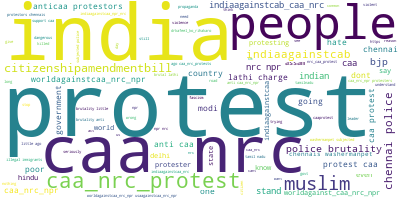

In [37]:
# Remove punctuation
Negative['tweet']= Negative['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the text to lowercase
Negative['tweet'] = Negative['tweet'].map(lambda x: x.lower())

# Join the different processed text together.
long_string = ','.join(list(Negative['tweet'].values))

wordcloud = WordCloud(background_color="white", max_words=100, contour_width=100, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [41]:
P=df[df.label==1]



In [42]:
N=df[df.label==-1]

In [43]:
P.head()

,text,sentiment,label
0,peaceful caa opposers not 'traitors anti-natio...,0.166667,1
2,mns dont have d rights to impose nrc n check a...,0.100000,1
3,yea right he has no business being appointed t...,0.285714,1
9,masha allah what's name of this baby look at h...,0.500000,1
10,@narendramodi modiji pl implement nrc across w...,0.066667,1
